1. get 30 items
2. recalculate the dataset into hourly averages
3. get a similarity, just try out cosine similarity
4. put the result of the similarity into a dendogram https://docs.scipy.org/doc//scipy-1.16.2/reference/generated/scipy.cluster.hierarchy.dendrogram.html

In [ ]:
import pandas as pd
import numpy as np
import random
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

NUMBER_OF_ITEMS = 200

# Set random seed for reproducibility
random.seed(42)

# Find the latest snapshot directory
cache_dir = Path("../data/cache")
snapshot_dirs = sorted(cache_dir.glob("prices_snapshot_*"))
latest_snapshot = snapshot_dirs[-1]
print(f"Using snapshot: {latest_snapshot.name}")

# Get all item_*.csv files
item_files = list(latest_snapshot.glob("item_*.csv"))
print(f"Total items available: {len(item_files)}")

# Randomly select items
selected_files = random.sample(item_files, NUMBER_OF_ITEMS)
print(f"Selected {len(selected_files)} random items")

# Fast parallel loading - only read columns we need
def load_item(file_path: Path) -> tuple[int, pd.DataFrame]:
    item_id = int(file_path.stem.split("_")[1])
    df = pd.read_csv(
        file_path,
        usecols=["fetched_at", "sell_unit_price"],  # Only needed columns
        dtype={"sell_unit_price": "int32"},  # Smaller dtype
    )
    return item_id, df

# Parallel loading with ThreadPoolExecutor
print("Loading data in parallel...")
with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(executor.map(load_item, selected_files))

items_data: dict[int, pd.DataFrame] = dict(results)
    
print(f"\nLoaded items: {sorted(items_data.keys())}")
print(f"\nSample data shape for first item: {list(items_data.values())[0].shape}")
list(items_data.values())[0].head()


Using snapshot: prices_snapshot_20251219_132555_tradable
Total items available: 27859
Selected 200 random items

Loaded items: [177, 285, 452, 910, 961, 1073, 1137, 1147, 1529, 1607, 1660, 1959, 2217, 2304, 2422, 2483, 2737, 2768, 3006, 3136, 3195, 3228, 3326, 3465, 3506, 3515, 5107, 5213, 5269, 5274, 8856, 9280, 10031, 10071, 10072, 10180, 10541, 10641, 10740, 10794, 10809, 10905, 10933, 11226, 11509, 12019, 12279, 12648, 12697, 12752, 12881, 12991, 13013, 13024, 13050, 13142, 13300, 13338, 13474, 13482, 13933, 13937, 14004, 14197, 14627, 14652, 14694, 14707, 14777, 14785, 14812, 14894, 15098, 15205, 15210, 15215, 15637, 19340, 19349, 20671, 20699, 24282, 24780, 24923, 24924, 25062, 25433, 25555, 25642, 25653, 25845, 26024, 26298, 26327, 26343, 26349, 26400, 26503, 26862, 26984, 27044, 27649, 27727, 27735, 27751, 27942, 28153, 28628, 28766, 28776, 28944, 28964, 29056, 30693, 32667, 32855, 32899, 33465, 33540, 33603, 34492, 34655, 34723, 34748, 34814, 36187, 36253, 36824, 36864, 37314,

,id,item_id,whitelisted,buy_quantity,buy_unit_price,sell_quantity,sell_unit_price,fetched_at,created_at
0,21152,47189,False,314,6000,212,6072,2025-07-29 14:45:21.388658+00:00,2025-07-29 14:45:21.388658+00:00
1,49341,47189,False,313,6000,212,6072,2025-07-29 14:50:21.307802+00:00,2025-07-29 14:50:21.307802+00:00
2,77330,47189,False,313,6000,212,6072,2025-07-29 14:55:21.283362+00:00,2025-07-29 14:55:21.283362+00:00
3,105519,47189,False,313,6000,212,6072,2025-07-29 15:00:29.629773+00:00,2025-07-29 15:00:29.629773+00:00
4,132908,47189,False,313,6000,212,6072,2025-07-29 15:05:24.803567+00:00,2025-07-29 15:05:24.803567+00:00


In [30]:
# Resample each item's sell_unit_price to hourly averages
hourly_prices: dict[int, pd.Series] = {}

for item_id, df in items_data.items():
    # Explicitly convert to datetime (ISO8601 handles mixed formats) and set as index
    df = df.copy()
    df["fetched_at"] = pd.to_datetime(df["fetched_at"], format="ISO8601")
    df_indexed = df.set_index("fetched_at")
    hourly_avg = df_indexed["sell_unit_price"].resample("1h").mean()
    hourly_prices[item_id] = hourly_avg

# Combine into single DataFrame (items as columns, timestamps as rows)
hourly_df = pd.DataFrame(hourly_prices)
print(f"Hourly DataFrame shape: {hourly_df.shape}")
print(f"Date range: {hourly_df.index.min()} to {hourly_df.index.max()}")
print(f"NaN count per item:\n{hourly_df.isna().sum()}")
hourly_df.head(10)


Hourly DataFrame shape: (3432, 200)
Date range: 2025-07-29 14:00:00+00:00 to 2025-12-19 13:00:00+00:00
NaN count per item:
47189    271
5269     268
910      268
77671    271
15098    271
        ... 
83895    272
11509    270
33540    273
5107     268
46016    269
Length: 200, dtype: int64


,47189,5269,910,77671,15098,13937,13142,10071,76807,3515,...,177,74388,73980,14652,32899,83895,11509,33540,5107,46016
fetched_at,,,,,,,,,,,,,,,,,,,,,
2025-07-29 14:00:00+00:00,6072.0,510.0,449.000000,288887.0,589.0,411.0,220.666667,499580.0,2893.0,34.0,...,422.00,282.000000,34267.00,5007.000000,3335.0,1249885.0,400.0,497.0,133.0,850.0
2025-07-29 15:00:00+00:00,6072.0,510.0,449.000000,288887.0,589.0,411.0,200.000000,499580.0,2893.0,34.0,...,422.00,281.333333,34267.00,5006.333333,3335.0,1249885.0,400.0,497.0,133.0,850.0
2025-07-29 16:00:00+00:00,6072.0,510.0,449.000000,288887.0,589.0,411.0,200.000000,499580.0,2893.0,34.0,...,421.25,281.916667,34267.00,5006.000000,3335.0,1249885.0,175.0,497.0,133.0,850.0
2025-07-29 17:00:00+00:00,6072.0,510.0,449.000000,288887.0,589.0,411.0,200.000000,499580.0,2893.0,34.0,...,420.25,282.000000,34267.00,5006.000000,3335.0,1249885.0,100.0,497.0,133.0,829.0
2025-07-29 18:00:00+00:00,6072.0,510.0,449.000000,288887.0,589.0,411.0,200.000000,499580.0,2893.0,34.0,...,420.00,282.000000,34267.00,5006.000000,3335.0,1249885.0,100.0,497.0,133.0,822.0
2025-07-29 19:00:00+00:00,6072.0,510.0,449.000000,283887.0,589.0,411.0,248.000000,499580.0,2893.0,34.0,...,420.00,282.000000,34267.00,5006.000000,3335.0,1249885.0,100.0,497.0,133.0,822.0
2025-07-29 20:00:00+00:00,6072.0,510.0,449.333333,258887.0,589.0,411.0,264.000000,499580.0,2893.0,34.0,...,420.00,282.000000,34267.00,5006.000000,3335.0,1249885.0,100.0,497.0,133.0,822.0
2025-07-29 21:00:00+00:00,6072.0,510.0,450.000000,258887.0,589.0,461.5,264.000000,499580.0,2893.0,34.0,...,420.00,281.750000,34267.00,5006.000000,3335.0,1249885.0,100.0,497.0,133.0,822.0
2025-07-29 22:00:00+00:00,6072.0,510.0,450.000000,258887.0,589.0,400.0,264.000000,499580.0,2893.0,34.0,...,420.00,281.000000,34267.00,5006.000000,3335.0,1249885.0,100.0,497.0,133.0,822.0


In [31]:
from sklearn.metrics.pairwise import cosine_similarity

# Handle NaN values (forward fill then backward fill)
hourly_filled = hourly_df.ffill().bfill()

# Transpose so items are rows (required for cosine_similarity)
price_matrix = hourly_filled.T.values

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(price_matrix)

# Convert to distance matrix (1 - similarity)
distance_matrix = 1 - similarity_matrix

print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"Similarity range: [{similarity_matrix.min():.4f}, {similarity_matrix.max():.4f}]")
pd.DataFrame(similarity_matrix, index=hourly_df.columns, columns=hourly_df.columns).head()


Similarity matrix shape: (200, 200)
Similarity range: [0.0000, 1.0000]


,47189,5269,910,77671,15098,13937,13142,10071,76807,3515,...,177,74388,73980,14652,32899,83895,11509,33540,5107,46016
47189,1.000000,0.993424,0.804543,0.991685,0.972619,0.987440,0.987854,0.993448,0.990016,0.991692,...,0.958622,0.983990,0.988377,0.993935,0.987138,0.981093,0.963268,0.974606,0.969561,0.948644
5269,0.993424,1.000000,0.800184,0.996882,0.963882,0.995390,0.994508,0.999896,0.995451,0.994606,...,0.965768,0.992259,0.996980,0.998632,0.995030,0.984086,0.958885,0.987633,0.975443,0.949685
910,0.804543,0.800184,1.000000,0.788575,0.812310,0.817520,0.780318,0.800134,0.796196,0.766770,...,0.760226,0.790158,0.790711,0.803027,0.759782,0.745955,0.772560,0.801115,0.772414,0.715093
77671,0.991685,0.996882,0.788575,1.000000,0.960075,0.990800,0.993628,0.996899,0.991415,0.992257,...,0.965574,0.990557,0.995674,0.994073,0.994767,0.987021,0.953060,0.981358,0.972329,0.955485
15098,0.972619,0.963882,0.812310,0.960075,1.000000,0.957343,0.953579,0.963856,0.956753,0.959851,...,0.938491,0.949106,0.952701,0.963734,0.950576,0.956627,0.927321,0.938952,0.953811,0.935420


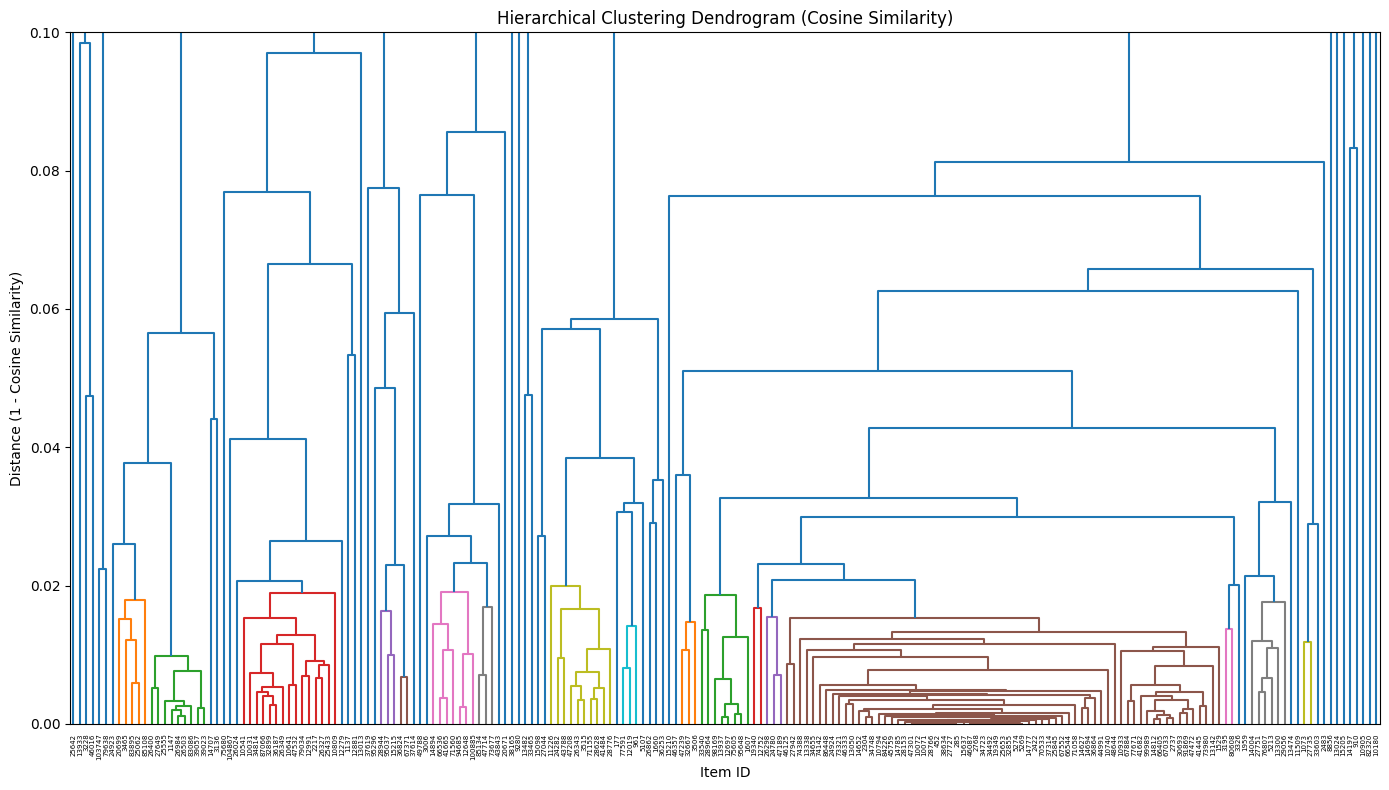

In [39]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# Fix floating point precision: ensure diagonal is exactly zero
distance_matrix_fixed = distance_matrix.copy()
np.fill_diagonal(distance_matrix_fixed, 0)

# Convert distance matrix to condensed form for linkage
condensed_dist = squareform(distance_matrix_fixed)

# Perform hierarchical clustering
linkage_matrix = linkage(condensed_dist, method="ward", optimal_ordering=True)

# Create dendrogram
plt.figure(figsize=(14, 8))
dendrogram(
    linkage_matrix,
    color_threshold=0.02,
    labels=[str(item_id) for item_id in hourly_df.columns],
    # above_threshold_color="black",
    # leaf_rotation=90,
    # leaf_font_size=10,
)
plt.title("Hierarchical Clustering Dendrogram (Cosine Similarity)")
plt.xlabel("Item ID")
plt.ylabel("Distance (1 - Cosine Similarity)")
plt.ylim(0, 0.1)
plt.tight_layout()
plt.show()


In [40]:
from scipy.cluster.hierarchy import fcluster

# Cut the dendrogram at different thresholds to get clusters
item_ids = list(hourly_df.columns)

# Try different numbers of clusters
for n_clusters in [3, 5, 10]:
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion="maxclust")
    
    print(f"\n{'='*60}")
    print(f"Clustering into {n_clusters} clusters:")
    print(f"{'='*60}")
    
    for cluster_id in range(1, n_clusters + 1):
        cluster_items = [item_ids[i] for i, label in enumerate(cluster_labels) if label == cluster_id]
        print(f"\nCluster {cluster_id} ({len(cluster_items)} items):")
        print(f"  Items: {cluster_items}")

# Show cluster assignments as a DataFrame for the 5-cluster solution
print(f"\n{'='*60}")
print("Detailed 5-cluster solution:")
print(f"{'='*60}")
cluster_labels_5 = fcluster(linkage_matrix, 5, criterion="maxclust")
cluster_df = pd.DataFrame({
    "item_id": item_ids,
    "cluster": cluster_labels_5
}).sort_values(["cluster", "item_id"])
display(cluster_df.groupby("cluster")["item_id"].apply(list).to_frame())



Clustering into 3 clusters:

Cluster 1 (198 items):
  Items: [47189, 5269, 910, 77671, 15098, 13937, 13142, 10071, 76807, 3515, 66405, 77591, 36253, 3006, 41484, 27727, 1137, 1073, 3228, 12991, 13474, 33465, 43788, 961, 37614, 12279, 73321, 47532, 71058, 36187, 27649, 13050, 28628, 41445, 15215, 95648, 285, 83086, 95037, 10794, 70533, 27751, 24924, 15205, 10641, 12881, 84226, 24780, 3506, 3195, 26343, 3326, 25555, 104867, 25062, 43843, 14694, 95296, 1529, 75680, 28964, 34723, 9280, 26298, 2737, 36824, 19340, 99989, 46125, 45759, 25642, 38634, 12019, 71560, 2422, 1607, 48644, 13300, 86448, 15637, 2768, 13482, 3465, 26349, 15210, 28766, 46357, 100885, 25845, 10905, 26024, 25433, 12648, 49788, 14785, 71155, 67371, 47472, 2483, 44991, 46333, 11226, 34655, 75605, 13933, 10933, 29056, 26327, 14894, 47208, 67884, 37314, 13024, 67552, 24282, 103747, 85108, 87066, 1959, 13338, 98169, 1147, 94685, 20699, 27044, 14812, 2304, 12697, 38165, 73677, 20671, 12752, 47714, 32855, 26862, 47301, 28944, 1

,item_id
cluster,
1,"[177, 285, 452, 961, 1073, 1137, 1147, 1529, 1..."
2,"[910, 10905, 14197, 15205]"
3,[25642]
4,[82320]
5,[10180]
